In [2]:
import numpy as np
from uncertainties import ufloat, unumpy
from uncertainties.umath import *
from astropy.io import fits
from astropy.table import Table
import pandas
import matplotlib.pyplot as plt
from astropy.stats import LombScargle
from scipy import signal
from importlib import reload as reload
import warnings
warnings.filterwarnings("ignore")

# Changing Dir to One With Module

In [3]:
pwd

'/Users/lenatreiber/Desktop/RXJ0529'

In [4]:
cd ../Yale/ 

/Users/lenatreiber/Desktop/Yale


In [5]:
#import hardnessratios as h
import pulsations as p

In [6]:
#set path to .evt files; where images should be saved
path = 'LXP_69_NICER/'

In [7]:
def sf(filename):
    '''
    Saves figure in LXP_69_NICER/0.3-8.0Figs/
    '''
    plt.savefig('LXP_69_NICER/0.3-8.0Figs/'+filename+'.png',dpi=200,bbox_inches='tight')

# Load in Data and Filter for Energy 
- hard+soft, soft, hard
- now hard+soft doesn't include all events
- also only gti, without high bg now

In [8]:
ed = p.readevt(path+'rxj0529_gti_bary.evt')

In [9]:
#energy filtering
ed = ed[ed['PI']>=30]
ed = ed[ed['PI']<=800] #this notebook: only up to 800 = 8 keV

In [10]:
len(ed)

60203

In [11]:
soft_evt = ed[ed['PI']<=150]
hard_evt = ed[ed['PI']>150]

# Find Exposure Time for These Events -- 6751 s

In [12]:
gti_list = fits.open(path+'kgfilt2.gti', memmap=True)

In [13]:
tab1 = Table(gti_list[1].data)

In [14]:
exptime = np.sum(tab1['STOP']-tab1['START']) #check
exptime

6751.0

# Frequency Search With These Data (HENDRICS)
.014 to .015 for gti, only these energies
oversample=50
f 0.01455985213471527
pd about 68.682

updated from: 0.014559697522140093 (and one with finer search)

In [15]:
f = 0.01455985213471527
pd = 1/f
pd

68.68201618721699

In [16]:
pd

68.68201618721699

# Average Count Rate of Total, Soft, Hard (Before Bg-Sub)


In [17]:
print('avg soft count rate: ',len(soft_evt)/exptime)
print('avg hard count rate: ',len(hard_evt)/exptime) 
print('avg count rate: ',len(ed)/exptime) 
print((len(soft_evt)/exptime)+(len(hard_evt)/exptime))

avg soft count rate:  4.484965190342171
avg hard count rate:  4.432676640497704
avg count rate:  8.917641830839875
8.917641830839875


# Calculate How Much Background to Subtract

Georgios: "For the 0.3-1.5: good counts are 91.4 %, so background is 8.6% of counts.
for 1.5-10.0 keV, good counts are 91.9% so BG is 8.1% of counts
So if the average count rate is 10 c/s you subtract 0.83 from all bins of the PP."

In [18]:
#how much to subtract from each soft bin
ssub = .086*len(soft_evt)/exptime #avg rate * percentage that's BG
hsub = .081*len(hard_evt)/exptime
tsub = .083*len(ed)/exptime
print(ssub,hsub,tsub)

0.38570700636942673 0.35904680788031407 0.7401642719597097


# Frequency Search Stingray

In [19]:
#checking if nans b/c of gti file -- yes!
eds = p.readevt('LXP_69_NICER/rxj0529_bary.evt')
eds = eds[eds['PI']>=30]
eds = eds[eds['PI']<=800] #constrain to 0.3 to 8.0 keV

In [20]:
df_min = 1/(eds['TIME'].max() - eds['TIME'].min())
oversampling=1
df = df_min / oversampling
frequencies = np.arange(.0146 - 200 * df, .0146 + 200 * df, df)

In [22]:
from stingray.pulse.search import epoch_folding_search, z_n_search
nbin=32
df_min = 1/exptime
oversampling=10
df = df_min / oversampling
frequencies = np.arange(1/pd - 200 * df, 1/pd + 200 * df, df)

freq, efstat = epoch_folding_search(eds['TIME'], frequencies, nbin=nbin)

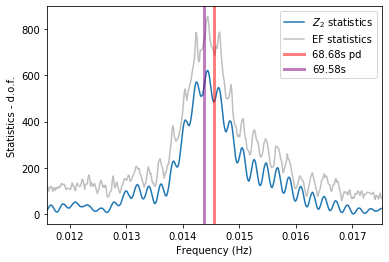

In [23]:

nharm = 1 
nbin = 32
freq, zstat = z_n_search(eds['TIME'], frequencies, nbin=nbin, nharm=nharm)

# ---- PLOTTING --------
plt.figure()
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/pd, color='r', lw=3, alpha=0.5, label='68.68s pd')
plt.axvline(1/69.58, color='purple', lw=3, alpha=0.5, label='69.58s')

plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()
#plt.figure(figsize=(15, 5))
#plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
#plt.plot(freq, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

In [24]:
df

1.4812620352540363e-05

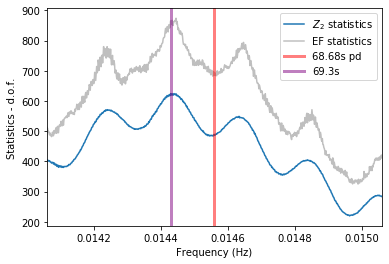

In [25]:
#finer search
frequencies = np.arange(1/pd - .0005, 1/pd + .0005, df/10)
freq, zstat = z_n_search(eds['TIME'], frequencies, nbin=nbin, nharm=nharm)
freqe, efstat = epoch_folding_search(eds['TIME'], frequencies, nbin=nbin)
# ---- PLOTTING --------
plt.figure()
plt.plot(freq, (zstat - nharm), label='$Z_2$ statistics')
plt.plot(freqe, efstat - nbin + 1, color='gray', label='EF statistics', alpha=0.5)

plt.axvline(1/pd, color='r', lw=3, alpha=0.5, label='68.68s pd')
plt.axvline(.01443, color='purple', lw=3, alpha=0.5, label='69.3s')

plt.xlim([frequencies[0], frequencies[-1]])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Statistics - d.o.f.')
plt.legend()

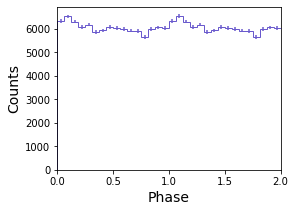

In [26]:
#what happens if we fold with this result?
stingh,stingm = p.phasehist(eds,69.3,bins=32,figsize=(4,3)) 

# 0.3-7.5 keV to Compare to 2003 Paper
they give period of 69.232 s


In [27]:
ppd = 69.232 #paper period

In [28]:
paper = ed[ed['PI']<=750] #to compare to paper

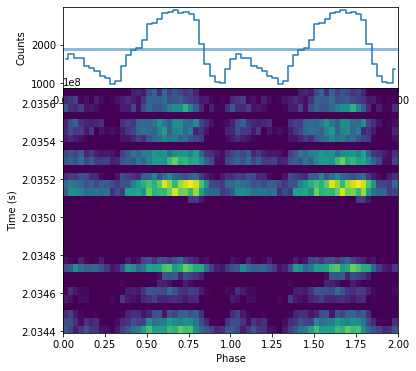

In [29]:
p.stingphase(paper,f,figsize=(6,6)) #and 1/ppd clearly doesn't work
sf('.3-7.5stingphase')

In [30]:
bg=[tsub,ssub,hsub] #background argument,subtracting once y-axis is counts/s

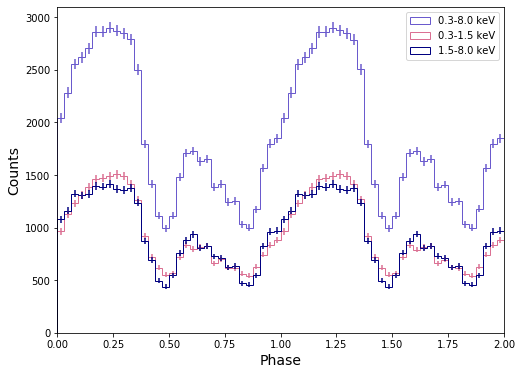

In [31]:
#32 phase bins
hists3,mids3 = p.phasehist_sh([ed,soft_evt,hard_evt],pd,ens=['0.3-8.0 keV','0.3-1.5 keV','1.5-8.0 keV'],
                              bins=64)
sf('countsphase')

> The plot above shows 32 phase bins, but 64 total thanks to the repeat of the phase. An interesting comparison can be made between this plot and the same one with an upper limit of 10 rather than 8 keV. We see that while the harder band has a higher count rate than the soft at the smaller peak, the soft's count rate exceeds the hard in the primary peak, which wasn't the case for the larger band. Otherwise, we still see the ascents are harder than the descents, where the relative relationship flips.

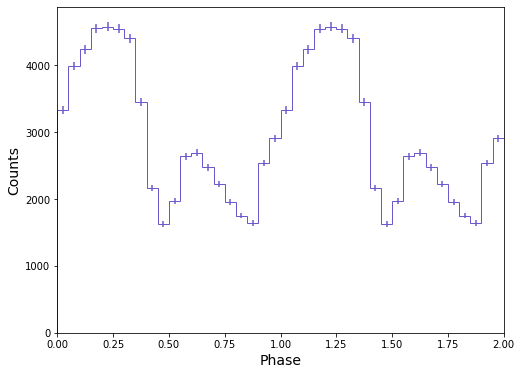

In [32]:
#bins to match paper
reload(p)
paphist3,pmids3 = p.phasehist(paper,pd,bins=40) 

# Counts/s Hists; BG-Subtract

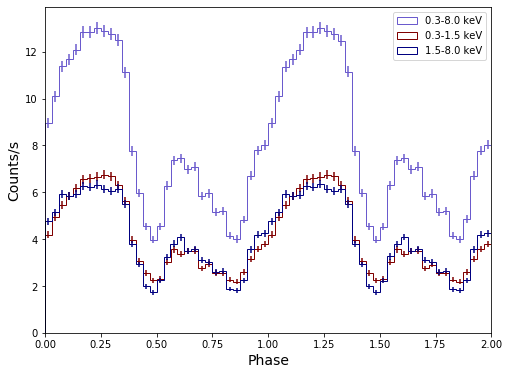

In [33]:
#convert to count rate and subtract background
reload(p)
ratehbg,bgerrs = p.phaserate(hists3,mids3,exptime,ens=['0.3-8.0 keV','0.3-1.5 keV','1.5-8.0 keV'],
                             bgb=True,bg=bg)
#plt.savefig('LXP_69_NICER/64bgsub.png',dpi=200,bbox_inches='tight')
sf('bgsubcrphase')

shift phase?

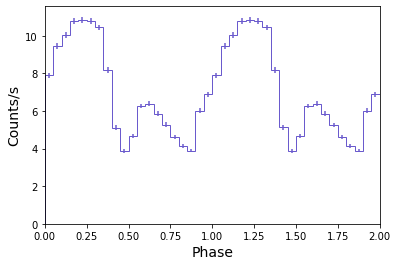

In [34]:
pcr,pcrerr = p.s_phaserate(paphist3,pmids3,exptime)
#sf('.3-7.5cr')

# Hardness Ratio

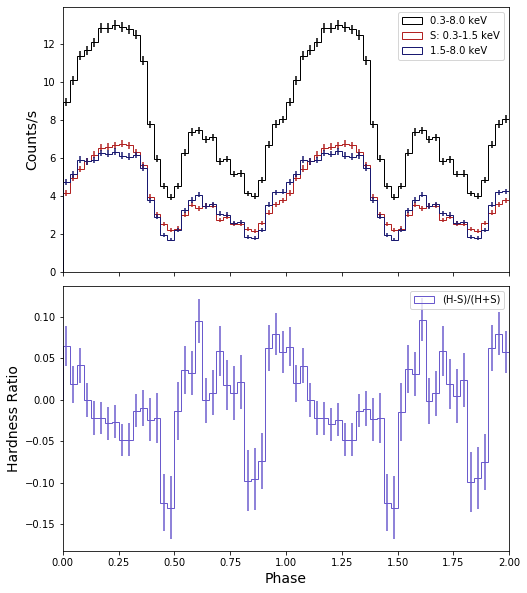

In [35]:
reload(p)
#background-subtracted, 32 phase bins (16 in "final" notebook)
rateh,rateherr = p.phaserate(hists3,mids3,exptime,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],rate=True,figsize=(8,10),bgb=True,bg=bg)
#plt.yticks(np.arange(-.08,.12,.02))

#plt.savefig('LXP_69_NICER/newcountshr.png',dpi=200,bbox_inches='tight')
#sf('bgsubcrphasehr')

# Calculations for 32 Phase Bins
- adding uncertainty 

In [36]:
totrate32 = ratehbg[0][0] #32 phase bins, bg-subtracted
totrerr = bgerrs[0]
totbins32 = ratehbg[0][1]
softrate32 = ratehbg[1][0]
softrerr = bgerrs[1]
hardrate32 = ratehbg[2][0]
hardrerr = bgerrs[2]

In [37]:
print('min hardness ratio: ',np.min((hardrate32-softrate32)/(hardrate32+softrate32)))
print('max hardness ratio: ',np.max((hardrate32-softrate32)/(hardrate32+softrate32)))

min hardness ratio:  -0.12980967666506862
max hardness ratio:  0.09639924702626118


In [38]:
import scipy.stats as st

In [39]:
print('min soft rate: ',np.min(softrate32),np.min(softrerr))
print('max soft rate: ',np.max(softrate32), np.max(softrerr))
print('mean soft rate: ',np.mean(softrate32))
print('soft standard error', st.sem(softrate32))

print('min hard rate: ',np.min(hardrate32),np.min(hardrerr))
print('max hard rate: ',np.max(hardrate32),np.max(hardrerr))
print('mean hard rate: ',np.mean(hardrate32))
print('hard standard error', st.sem(hardrate32))


print('min total rate: ',np.min(totrate32),np.min(totrerr))
print('max total rate: ',np.max(totrate32),np.max(totrerr))
print('mean total rate: ',np.mean(totrate32))
print('total standard error', st.sem(totrate32))

min soft rate:  2.188133906087984 0.11045408571393672
max soft rate:  6.752790993926823 0.1839476975801606
mean soft rate:  4.099258183972744
soft standard error 0.20066162690447276
min hard rate:  1.7218300992445563 0.09931483615349175
max hard rate:  6.35284772626278 0.17836658483521164
mean hard rate:  4.0736298326173905
hard standard error 0.194996783695538
min total rate:  3.9619539327507027 0.14929240229203256
max total rate:  13.005947415197753 0.25525888583662293
mean total rate:  8.177477558880163
total standard error 0.3929534137878577


> **pulsed fraction is further down**

# Compare to Paper
> load in extracted data from 2003 paper pulse profile

In [40]:
papdata = pandas.read_csv(path+'2003PP.csv',names=['Phase','Int']) #normalized intensity

In [41]:
papdata[:5] 

,Phase,Int
0,0.0025,0.395561
1,0.0525,0.839426
2,0.1025,1.283290
3,0.1500,1.186684
4,0.2025,1.332898


In [42]:
(papdata['Phase'][1]-papdata['Phase'][0])*(2/3)

0.03333333333333336

## error updated later; just approximated here

Text(0, 0.5, 'Counts/s')

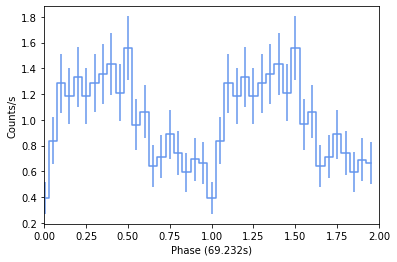

In [43]:
plt.step(papdata['Phase'],papdata['Int'],where='mid',color='cornflowerblue')
plt.xlim(0,2) #no error; 69.3 second phase
plt.errorbar(papdata['Phase'],papdata['Int'],yerr=np.sqrt(papdata['Int'])*.2,linestyle='none',color='cornflowerblue')
plt.xlabel('Phase (69.232s)')
plt.ylabel('Counts/s')
#sf('papapproxerr')

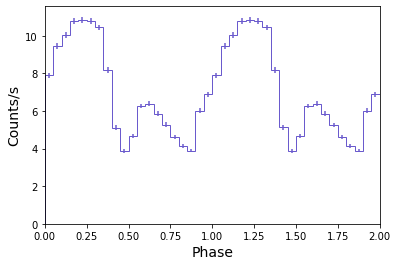

In [44]:
p3,p3err = p.s_phaserate(paphist3,pmids3,exptime) #same number of bins (20 phase)

In [45]:
(papdata['Int'].max()-papdata['Int'].min())/(papdata['Int'].max()+papdata['Int'].min())

0.5943775100401607

In [46]:
(p3[0].max()-p3[0].min())/(p3[0].max()+p3[0].min())

0.4748711340206183

In [47]:
papdata['Int'].max()/np.median(papdata['Int'])

1.5347938144329896

In [48]:
np.mean(p3[0]) - p3[0].min()

3.209124574137162

In [49]:
#simple pulsed fraction
print(papdata['Int'].max()/np.median(papdata['Int']))
print(paphist3[0].max()/np.median(paphist3[0]))

1.5347938144329896
1.7178236397748592


# Shift Phase, Compare to 2003 Paper
moved to module
s_phaserate now returns error as well
different bins here

In [50]:
np.mean(p3[0])/papdata['Int'].mean()

7.063956274550847

> - paper errors not exact right now
- two profiles phase-folded with different periods
- scaled based on means
- how do you adjust the error when you scale up like this?

Text(0, 0.5, 'Counts/s (0.3-7.5 keV)')

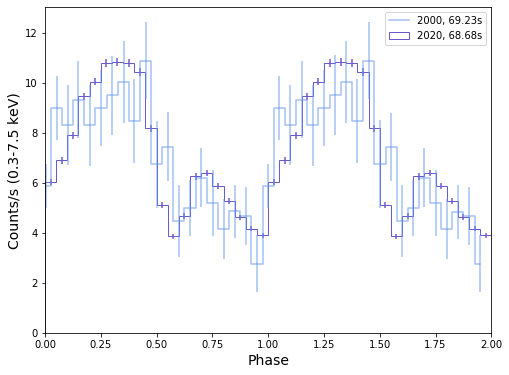

In [51]:
reload(p) #now in module
mod = p.phaseroll(p3[1],p3[0],2,pmids3,p3err,label='2020, 68.68s')
#plt.savefig(path+'shiftedpp.png',dpi=200,bbox_inches='tight')
paproll = np.roll(papdata['Int'],-1)
#paproll=papdata['Int']
plt.step(papdata['Phase'],7*paproll,where='mid',color='cornflowerblue',alpha=.6,label='2000, 69.23s')
plt.errorbar(papdata['Phase'],7*paproll,yerr=7*np.sqrt(papdata['Int'])*.2,alpha=.6,linestyle='none',color='cornflowerblue')
plt.legend()
plt.ylabel('Counts/s (0.3-7.5 keV)')
#plt.savefig(path+'papdataandours.png',dpi=200,bbox_inches='tight')
#sf('0020cr')

# Overall Pulsed Fraction
rms first, then (max-min)/(max+min)

move these to module when done

In [52]:
#adding error propogation
def pferr(countrate,err): 
    totlen = len(countrate)
    r=countrate[:int(totlen/2)] #count rate in phase bins up to 1
    err=err[:int(totlen/2)]
    rerr=unumpy.uarray(r,err)
    avgr = np.mean(rerr)
    num = np.sum(((rerr-avgr)**2)/20)
    num = (num)**(1/2)
    full = num/avgr
    return full

In [53]:
pferr(ratehbg[0][0],bgerrs[0]) #32 phase bins

0.48246315056901207+/-0.005597423781517722

In [54]:
pferr(ratehbg[1][0],bgerrs[1])

0.49148394573529963+/-0.008178564348926018

In [55]:
pferr(ratehbg[2][0],bgerrs[2])

0.4805684009952531+/-0.007614499572182582

In [56]:
def pf2(countrate,err):
    totlen = len(countrate)
    r=countrate[:int(totlen/2)]
    err=err[:int(totlen/2)]
    rerr=unumpy.uarray(r,err)
    rmax = rerr.max()
    rmin = rerr.min()
    pf = (rmax-rmin)/(rmax+rmin)#count rate in phase bins up to 1
    return pf

In [57]:
pf2(ratehbg[0][0],bgerrs[0])

0.5330060151216365+/-0.01520808059435855

In [58]:
pf2(ratehbg[1][0],bgerrs[1]) #soft

0.5105352230205266+/-0.02120452942821342

In [59]:
pf2(ratehbg[2][0],bgerrs[2]) #hard

0.5722680703523226+/-0.021578977919208507

# Pulsed Fraction as Function of Energy
> not bg-subtracted

In [61]:
#make tables for energies
en1 = ed[ed['PI']<=70]
en2 = ed[ed['PI']>70]
en2 = en2[en2['PI']<=100]
en3 = ed[ed['PI']>100]
en3 = en3[en3['PI']<=150]
en4 = ed[ed['PI']>150]
en4 = en4[en4['PI']<=200]
en5 = ed[ed['PI']>200]
en5 = en5[en5['PI']<=300]
en6 = ed[ed['PI']>300]
en6 = en6[en6['PI']<=500]
en7 = ed[ed['PI']>500]
en7 = en7[en7['PI']<=800]

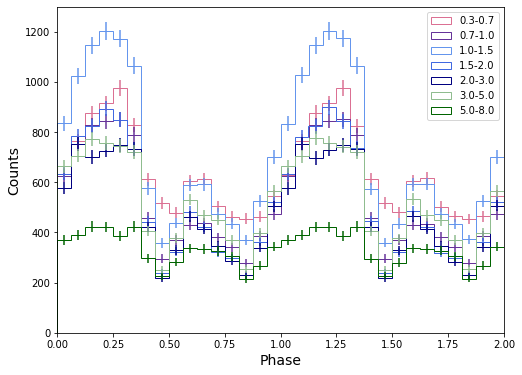

In [62]:
#up to 8.0 for now since higher energies filtered out
pfens,pfmids = p.phasehist_sh([en1,en2,en3,en4,en5,en6,en7],pd,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'])
#sf('pfcounts')

In [63]:
np.min(pfens[-1][0]) #minimum counts in a bin 5-8 keV 

215.0

In [64]:
pf = []
pfn = []
pfe = []
for i in range(7):
    cr = pfens[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)]
    rerr = unumpy.uarray(r,np.sqrt(r))
    rmax = rerr.max()
    rmin = rerr.min()
    pf.append((rmax-rmin)/(rmax+rmin))
    pfn.append(((rmax-rmin)/(rmax+rmin)).n)
    pfe.append(((rmax-rmin)/(rmax+rmin)).s)
pfn

[0.36363636363636365,
 0.5079928952042628,
 0.5413196668802049,
 0.5903829029385574,
 0.5493827160493827,
 0.51171875,
 0.32601880877742945]

In [65]:
pfe

[0.024633943763506118,
 0.02566942494347982,
 0.021281388894805027,
 0.02408518623201136,
 0.0268009472397669,
 0.026848532040921348,
 0.037427290772251987]

Text(0, 0.5, 'Pulsed Fraction')

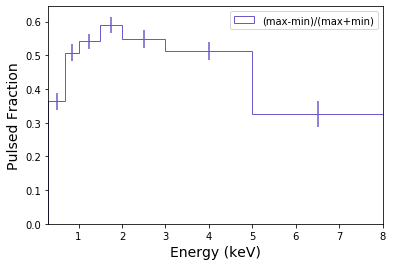

In [66]:
#plot as function of energy
enbins = [.3,.7,1,1.5,2,3,5,8]
plt.hist(enbins[:-1],enbins,weights=pfn,color='slateblue',histtype='step',label='(max-min)/(max+min)')
plt.xlim(.3,8)
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfn,yerr=pfe,linestyle='none',color='slateblue')
plt.legend()
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('Pulsed Fraction',fontsize=14)
#sf('pfenergy')

In [67]:
#how much to subtract from each soft bin
bg1 = .132*len(en1)/exptime #avg rate * percentage that's BG
bg2 = .068*len(en2)/exptime
bg3 = .058*len(en3)/exptime
bg4 = .055*len(en4)/exptime
bg5 = .064*len(en5)/exptime
bg6 = .075*len(en6)/exptime
bg7 = .143*len(en7)/exptime

pfbg = [bg1,bg2,bg3,bg4,bg5,bg6,bg7]
pfbg2 = 2*np.array(pfbg) #doubles each background value
pfbg

[0.20031699007554438,
 0.0859392682565546,
 0.0988087690712487,
 0.06810842838098059,
 0.073830839875574,
 0.09369723003999407,
 0.11317567767738113]

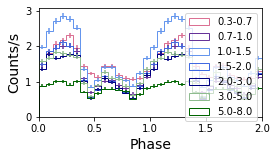

In [68]:
pfcr_ns,pfcrerr_ns = p.phaserate(pfens,pfmids,exptime,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(4,2))

In [69]:
bg7

0.11317567767738113

In [70]:
np.min(pfcr_ns[-1][0])

0.5095541401273884

In [72]:
#calculating error as 80% of min in hardest bin
bgguess = 0.8*np.min(pfcr_ns[-1][0])/bg7

bg1_g = bgguess*.132*len(en1)/exptime #avg rate * percentage that's BG
bg2_g = bgguess*.068*len(en2)/exptime
bg3_g = bgguess*.058*len(en3)/exptime
bg4_g = bgguess*.055*len(en4)/exptime
bg5_g = bgguess*.064*len(en5)/exptime
bg6_g = bgguess*.075*len(en6)/exptime
bg7_g = bgguess*.143*len(en7)/exptime
pfbg_g = [bg1_g,bg2_g,bg3_g,bg4_g,bg5_g,bg6_g,bg7_g]

In [73]:
pfbg_g

[0.7215144011547664,
 0.3095414904568139,
 0.3558956722462518,
 0.24531724392605522,
 0.26592858748271325,
 0.337484607754298,
 0.4076433121019107]

In [74]:
pfbg

[0.20031699007554438,
 0.0859392682565546,
 0.0988087690712487,
 0.06810842838098059,
 0.073830839875574,
 0.09369723003999407,
 0.11317567767738113]

- minimum count rate in hardest bin is .5096...
- 

If I recall correctly the BG at 5.0-8.0 is about 0.1 c/s, or lets say X?
The minimum in the pulse profile in the 5.0-8.0 keV band is about 0.5 c/s (or just Y), so it is reasonable to say that BG cannot be higher than that.
So lets say that BG contribution in the 5.0-8.0 keV is about 80.0% of that minimum, i.e 0.8*Y

Then we can scale the NICER BG by Z=0.8*Y/X, so we can scale the BG in all energy bands by this Z value in a similar way that you did before for Z=2, see plot below:

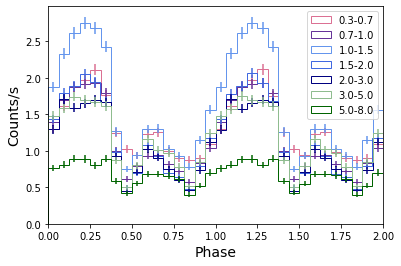

In [75]:
#make bg-subtracted count rate hist
reload(p)
pfcr,pfcrerr = p.phaserate(pfens,pfmids,exptime,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(6,4),bgb=True,bg=pfbg)
#sf('pfcr')


In [76]:
pfbg2

array([0.40063398, 0.17187854, 0.19761754, 0.13621686, 0.14766168,
       0.18739446, 0.22635136])

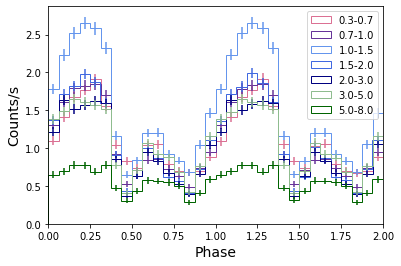

In [77]:
#count rate hist with doubled background
pfcr2,pfcrerr2 = p.phaserate(pfens,pfmids,exptime,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(6,4),bgb=True,bg=pfbg2)

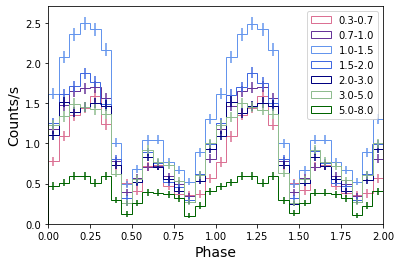

In [78]:
#.8 scaling
pfcrg,pfcrerrg = p.phaserate(pfens,pfmids,exptime,ens=['0.3-0.7','0.7-1.0','1.0-1.5','1.5-2.0','2.0-3.0','3.0-5.0','5.0-8.0'],
               colors=['palevioletred','rebeccapurple','cornflowerblue','royalblue','navy','darkseagreen','darkgreen'],
                           rate=False,figsize=(6,4),bgb=True,bg=pfbg_g)

In [79]:
(np.max(pfcrg[-1][0])-np.min(pfcrg[-1][0]))/(np.max(pfcrg[-1][0])+np.min(pfcrg[-1][0]))

0.7074829931972793

In [80]:
#original bg-subtraction
pfr = [] #adding r to variables (for rate)
pfnr = []
pfer = []
for i in range(7):
    cr = pfcr[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)] #first half of count rates, since second half just repeated
    e = pfcrerr[i][:int(totlen/2)] #errors originally from sqrt of counts
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    pfr.append((rmax-rmin)/(rmax+rmin))
    pfnr.append(((rmax-rmin)/(rmax+rmin)).n) #value
    pfer.append(((rmax-rmin)/(rmax+rmin)).s) #propogated error
pfnr

[0.4123850328024533,
 0.5429634031275452,
 0.5718664383938262,
 0.6222284789188436,
 0.5870092866188262,
 0.554537697848389,
 0.3834144671218636]

In [81]:
#guess with 0.8
pfrg = [] #adding r to variables (for rate)
pfnrg = []
pferg = []
for i in range(7):
    cr = pfcrg[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)] #first half of count rates, since second half just repeated
    e = pfcrerrg[i][:int(totlen/2)] #errors originally from sqrt of counts
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    pfrg.append((rmax-rmin)/(rmax+rmin))
    pfnrg.append(((rmax-rmin)/(rmax+rmin)).n) #value
    pferg.append(((rmax-rmin)/(rmax+rmin)).s) #propogated error
pfnrg

[0.6332720902477272,
 0.6614355634087871,
 0.6702792791825964,
 0.7238126303405059,
 0.7142957338808729,
 0.7088694946482104,
 0.707482993197279]

In [82]:
pfr2 = [] #adding r to variables (for rate)
pfnr2 = []
pfer2 = []
for i in range(7):
    cr = pfcr2[i][0]
    totlen = len(cr)
    r = cr[:int(totlen/2)]
    e = pfcrerr2[i][:int(totlen/2)]
    rerr = unumpy.uarray(r,e)
    rmax = rerr.max()
    rmin = rerr.min()
    pfr2.append((rmax-rmin)/(rmax+rmin))
    pfnr2.append(((rmax-rmin)/(rmax+rmin)).n)
    pfer2.append(((rmax-rmin)/(rmax+rmin)).s)
pfnr2

[0.4762275451843786,
 0.58310464485665,
 0.606066909069522,
 0.6577054709587817,
 0.6301688002718934,
 0.6051769189680807,
 0.46533713731528414]

Text(0, 0.5, 'PF')

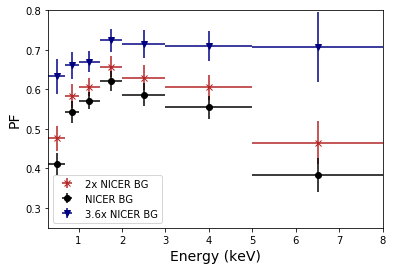

In [83]:
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnr2,yerr=pfer2,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='x',color='firebrick',linestyle='none',label='2x NICER BG')
plt.xlim(.3,8)
#plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnr,yerr=pfer,linestyle='none',color='slateblue')
#adding original
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnr,yerr=pfer,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='o',linestyle='none',color='black',label='NICER BG')
#guess with .8
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnrg,yerr=pferg,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='v',linestyle='none',color='navy',label='3.6x NICER BG')

plt.legend(loc = 'lower left')
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylim(.25,.8)
plt.ylabel('PF',fontsize=14)
#sf('2bgpf')


In [84]:
rms_pf = []
rms_pfe = []
for i in range(7):
    cr = pfcr[i][0]
    e = pfcrerr[i]
    rms_pf.append(pferr(cr,e).n)
    rms_pfe.append(pferr(cr,e).s)

In [85]:
rms_pf2 = []
rms_pfe2 = []
for i in range(7):
    cr = pfcr2[i][0]
    e = pfcrerr2[i]
    rms_pf2.append(pferr(cr,e).n)
    rms_pfe2.append(pferr(cr,e).s)

In [86]:
rms_pfe

[0.010721650657868375,
 0.010560389596154114,
 0.008941240448327692,
 0.010158108592121618,
 0.010429001612597322,
 0.009926014054985935,
 0.013670793009163504]

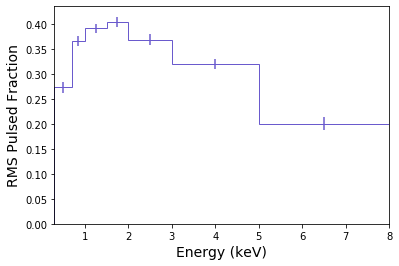

In [87]:
#rms pf vs energy hist
enbins = [.3,.7,1,1.5,2,3,5,8]
plt.hist(enbins[:-1],enbins,weights=rms_pf,color='slateblue',histtype='step')
plt.xlim(.3,8)
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],rms_pf,yerr=rms_pfe,linestyle='none',color='slateblue')
plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('RMS Pulsed Fraction',fontsize=14)
sf('rmspf')

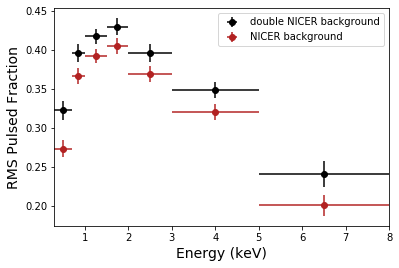

In [88]:
#double the background
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],rms_pf2,yerr=rms_pfe2,xerr=[.2,.15,.25,.25,.5,1,1.5],marker='o',color='black',linestyle='none',label='double NICER background')
plt.xlim(.3,8)
#plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],pfnr,yerr=pfer,linestyle='none',color='slateblue')
#adding original background
plt.errorbar([.5,.85,1.25,1.75,2.5,4,6.5],rms_pf,yerr=rms_pfe,xerr=[.2,.15,.25,.25,.5,1,1.5],linestyle='none',marker='o',color='firebrick',label='NICER background')

plt.xlabel('Energy (keV)',fontsize=14)
plt.ylabel('RMS Pulsed Fraction',fontsize=14)
plt.legend()
#sf('2bgpfrms')

# 2D Histograms
- phase, time
- energy

Text(0, 0.5, 'Time (s)')

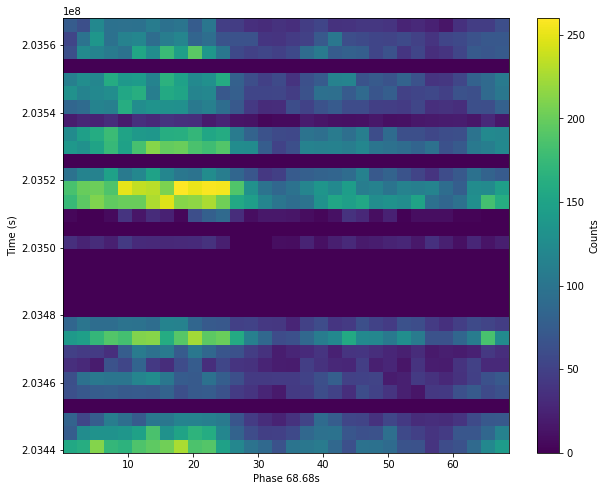

In [89]:
ph = ed['TIME']%pd
plt.figure(figsize=(10,8)) 
hist = plt.hist2d(ph,ed['TIME'],bins=32)
plt.colorbar(label='Counts')
plt.xlabel('Phase 68.68s')
plt.ylabel('Time (s)')
#sf('simple2dhist')

Text(0, 0.5, 'Counts')

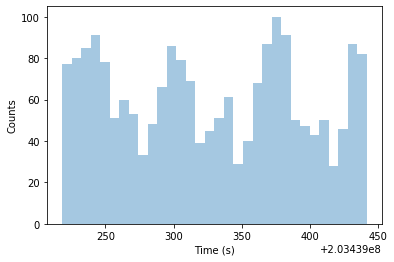

In [90]:
import seaborn as sb
sb.distplot(ed['TIME'][:2000],kde=False,bins=32)
plt.xlabel('Time (s)')
plt.ylabel('Counts')
#sf('timecountshist32b')

Text(0.5, 0, 'Phase (68.68s)')

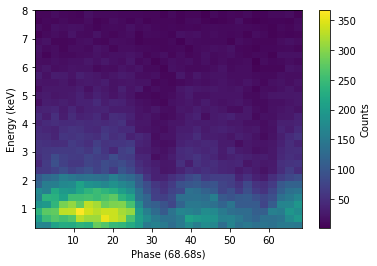

In [91]:
enhist1 = plt.hist2d(ph,ed['PI']/100,bins=32)
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase (68.68s)')

In [92]:
pwd

'/Users/lenatreiber/Desktop/Yale'

In [93]:
enbg = np.loadtxt('LXP_69_NICER/BG_rate32.ascii')

In [94]:
enbg[:,1] #energy bin on left, count rate to subtract on right

array([0.12898389, 0.09495822, 0.06578335, 0.04942853, 0.04444942,
       0.03716503, 0.02883169, 0.02353626, 0.01784542, 0.01538645,
       0.01417338, 0.01287377, 0.01189645, 0.01129514, 0.01069084,
       0.01013578, 0.01017308, 0.00941062, 0.00916443, 0.00868248,
       0.00836914, 0.00811847, 0.00803491, 0.00773351, 0.00813787,
       0.00793644, 0.00756341, 0.00733662, 0.00740824, 0.00889287,
       0.00744703, 0.00731871])

Text(0.5, 0, 'Phase')

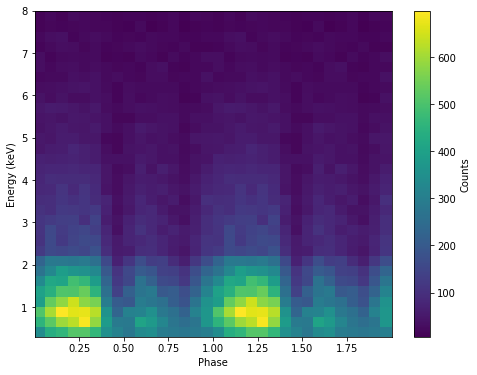

In [95]:
plt.figure(figsize=(8,6)) 
ph1 = ph/pd
ph2 = ph1 + 1
ph3 = list(ph1)+list(ph2)
ed2 = list(ed['PI'])+list(ed['PI'])
enhist = plt.hist2d(ph3,np.array(ed2)/100,bins=32) #convert from PI to keV
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')
#sf('enphase2d')

In [96]:
#version with each row normalized
norm = np.zeros((32,32))
for i in range(32):
    norm[i,:] = enhist[0][:,31-i]/np.median(enhist[0][:,31-i])

In [97]:
#version with each row normalized; bg-subtracted
#convert to count rate -- make sure corresponding
norm_bg = np.zeros((32,32)) #16 phase bins
for i in range(32):
    norm_bg[i,:] = ((enhist[0][:,31-i]*16/exptime)-enbg[31-i,1]) #-enbg[i,1]
    norm_bg[i,:] = norm_bg[i,:]/np.median(norm_bg[i,:]) #16 phase bins

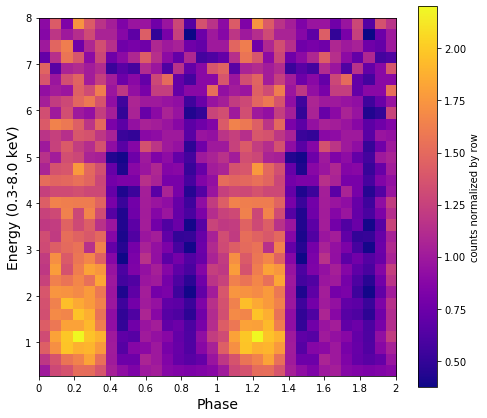

In [98]:
plt.figure(figsize=(8,7))
plt.imshow(norm,cmap='plasma')
plt.colorbar(label='counts normalized by row')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)
sf('enphasenorm')

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

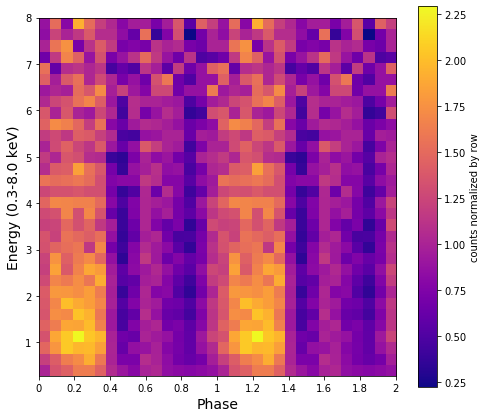

In [99]:
#bg-subtracted
plt.figure(figsize=(8,7))
plt.imshow(norm_bg,cmap='plasma')
plt.colorbar(label='counts normalized by row')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

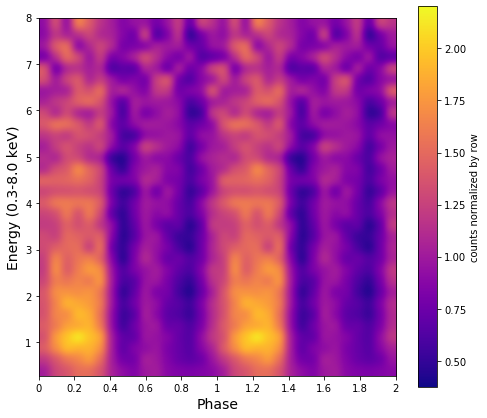

In [100]:
plt.figure(figsize=(8,7))
plt.imshow(norm,cmap='plasma',interpolation='gaussian')
plt.colorbar(label='counts normalized by row')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)
#sf('gsmoothenhist')

Text(0, 0.5, 'Energy (0.3-8.0 keV)')

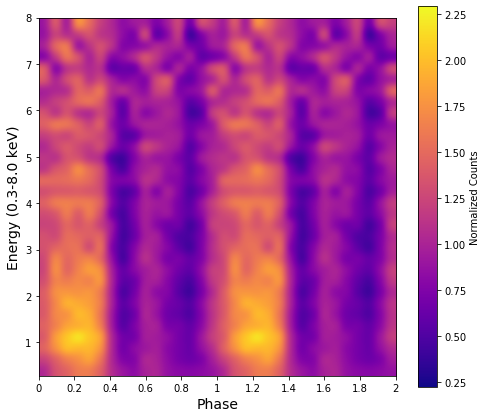

In [101]:
#smoothed with background-subtraction
plt.figure(figsize=(8,7))
plt.imshow(norm_bg,cmap='plasma',interpolation='gaussian')
plt.colorbar(label='Normalized Counts')
plt.yticks([28.5,28.5-32/7.7,28.5-2*32/7.7,28.5-3*32/7.7,28.5-4*32/7.7,28.5-5*32/7.7,28.5-6*32/7.7,28.5-7*32/7.7],[1,2,3,4,5,6,7,8])
plt.xticks([-0.5,2.7,6.4-.5,9.6-.5,12.8-.5,16-.5,19.2-.5,22.4-.5,25.6-.5,28.8-.5,31.5],[0,.2,.4,.6,.8,1,1.2,1.4,1.6,1.8,2])
plt.xlabel('Phase',fontsize=14)
plt.ylabel('Energy (0.3-8.0 keV)',fontsize=14)
#sf('bggsmoothenph')

In [146]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

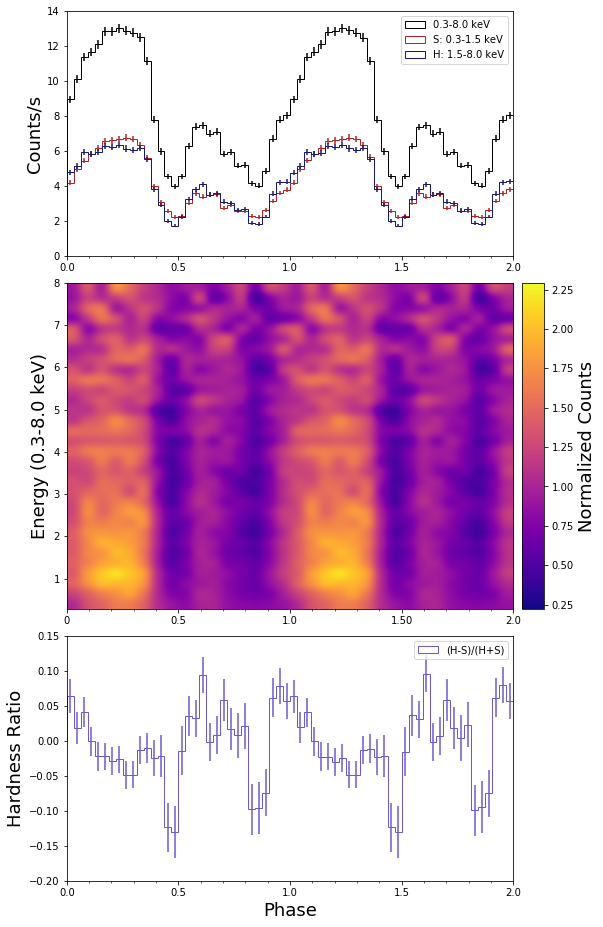

In [161]:
#heat map as middle panel with pulse profile and hardness ratios
reload(p)
#background-subtracted, 32 phase bins (16 in "final" notebook)
rateh,rateherr = p.phaserate(hists3,mids3,exptime,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','midnightblue'],rate=True,figsize=(8,16),bgb=True,bg=bg,enhist=True,ed=ed,pd=pd,enbg=enbg,norm_bg=norm_bg)

sf('threepulse')



### adding normalization by column instead of by row


In [103]:
normc = np.zeros((32,32))
for i in range(32):
    normc[:,i] = enhist[0][i,:]/np.median(enhist[0][i,:])

Text(0, 0.5, 'Energy')

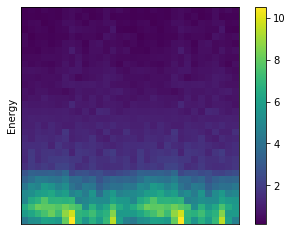

In [104]:
plt.imshow(normc,origin='lower') #does this make sense as the column normalization? but then why not just 1d hist
plt.yticks([])
plt.xticks([])
plt.colorbar()
plt.ylabel('Energy')

In [105]:
enhist[0][:,0] #row

array([339., 437., 460., 514., 513., 463., 351., 310., 281., 335., 347.,
       295., 285., 278., 287., 299., 339., 437., 460., 513., 514., 463.,
       351., 310., 281., 334., 348., 295., 285., 278., 287., 299.])

In [106]:
norm.shape

(32, 32)

In [107]:
enhist[0][2] #column

array([460., 597., 699., 585., 507., 412., 388., 284., 152., 122., 127.,
       131., 122., 114., 109.,  92.,  80.,  69.,  61.,  60.,  55.,  41.,
        54.,  40.,  35.,  23.,  30.,  24.,  33.,  34.,  16.,  13.])

In [108]:
enhist[1] #binning along x

array([7.66436565e-06, 6.25070443e-02, 1.25006424e-01, 1.87505804e-01,
       2.50005184e-01, 3.12504564e-01, 3.75003944e-01, 4.37503324e-01,
       5.00002704e-01, 5.62502084e-01, 6.25001463e-01, 6.87500843e-01,
       7.50000223e-01, 8.12499603e-01, 8.74998983e-01, 9.37498363e-01,
       9.99997743e-01, 1.06249712e+00, 1.12499650e+00, 1.18749588e+00,
       1.24999526e+00, 1.31249464e+00, 1.37499402e+00, 1.43749340e+00,
       1.49999278e+00, 1.56249216e+00, 1.62499154e+00, 1.68749092e+00,
       1.74999030e+00, 1.81248968e+00, 1.87498906e+00, 1.93748844e+00,
       1.99998782e+00])

In [109]:
enhist[2] #binning along y

array([0.3     , 0.540625, 0.78125 , 1.021875, 1.2625  , 1.503125,
       1.74375 , 1.984375, 2.225   , 2.465625, 2.70625 , 2.946875,
       3.1875  , 3.428125, 3.66875 , 3.909375, 4.15    , 4.390625,
       4.63125 , 4.871875, 5.1125  , 5.353125, 5.59375 , 5.834375,
       6.075   , 6.315625, 6.55625 , 6.796875, 7.0375  , 7.278125,
       7.51875 , 7.759375, 8.      ])

## hard and soft 2D hists

Text(0.5, 0, 'Phase')

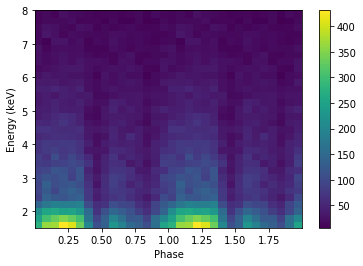

In [110]:
hph = hard_evt['TIME']%pd
hph1 = hph/pd
hph2 = hph1 + 1
hph3 = list(hph1)+list(hph2)
hed2 = list(hard_evt['PI'])+list(hard_evt['PI'])
enhisth = plt.hist2d(hph3,np.array(hed2)/100,bins=32)
plt.colorbar()
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')

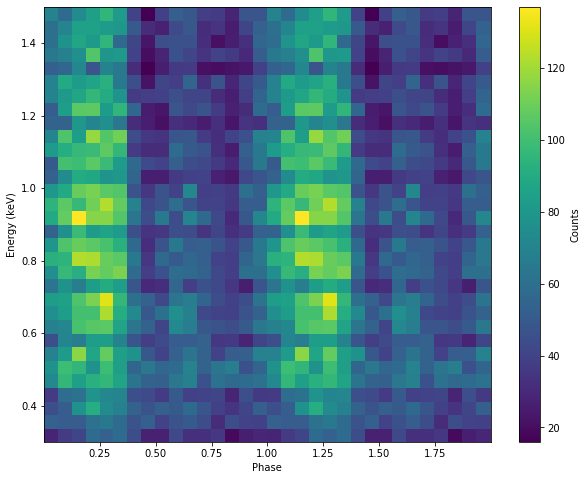

In [111]:
plt.figure(figsize=(10,8))
sph = soft_evt['TIME']%pd
sph1 = sph/pd
sph2 = sph1 + 1
sph3 = list(sph1)+list(sph2)
sed2 = list(soft_evt['PI'])+list(soft_evt['PI'])
enhists = plt.hist2d(sph3,np.array(sed2)/100,bins=32)
plt.colorbar(label='Counts')
plt.ylabel('Energy (keV)')
plt.xlabel('Phase')
sf('softenphase')

> stop for now, but there's probably a better way to use enhist to make 2d hist

# Paper Comparison With Extracted Errors
> and then find out luminosity then and now

In [112]:
pde = pandas.read_csv(path+'2000werrors.csv',names=['Phase','Int']) #normalized intensity

In [113]:
len(pde[40:])

80

In [114]:
p_err = []
for j in np.arange(0,40):
    p_err.append(pde['Int'][40+2*j])

In [115]:
p_err = np.array(p_err)

Text(0, 0.5, 'Counts/s (0.3-7.5 keV)')

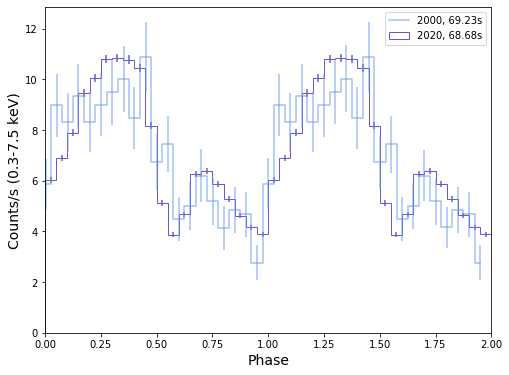

In [119]:
mod = p.phaseroll(p3[1],p3[0],2,np.array(pmids3),p3err,label='2020, 68.68s')
#plt.savefig(path+'shiftedpp.png',dpi=200,bbox_inches='tight')
paproll = np.roll(papdata['Int'],-1)
perroll = np.roll(p_err,-1)
#paproll=papdata['Int']
#perroll=p_err

plt.step(papdata['Phase'],7*paproll,where='mid',color='cornflowerblue',alpha=.6,label='2000, 69.23s')
plt.errorbar(papdata['Phase'],7*paproll,yerr=7*np.abs(perroll-paproll),alpha=.6,linestyle='none',color='cornflowerblue')
plt.legend()
plt.ylabel('Counts/s (0.3-7.5 keV)')
#sf('0020cr')

In [448]:
pwd

'/Users/lenatreiber/Desktop/Yale'

In [120]:
import hendrics.io
import hendrics.plot as hp

In [121]:
ez=hendrics.io.load_folding('LXP_69_NICER/rxj0529_gti_bary_0.3_10.0_nicer_xti_Z2n_0.01-0.02Hz.p')

INFO: Loading data and info from LXP_69_NICER/rxj0529_gti_bary_0.3_10.0_nicer_xti_Z2n_0.01-0.02Hz.p [hendrics.io]


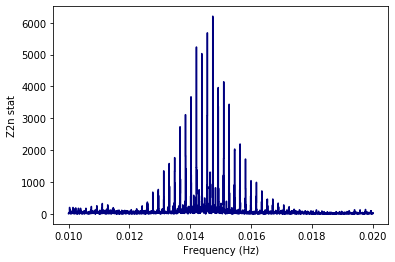

In [122]:
plt.plot(ez.freq, ez.stat, drawstyle='steps-mid',color='navy')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Z2n stat')
sf('Zsearch')

In [123]:
p_res = pandas.DataFrame(columns=['freq','stat']) #periodogram result
p_res['freq'] = ez.freq
p_res['stat'] = ez.stat 
p_res = p_res.sort_values(by='stat',ascending=False)

In [124]:
p_res[:5]

,freq,stat
1226,0.014739,6201.415044
1180,0.014561,5680.922022
1087,0.014202,5234.783437
1133,0.014379,5029.650336
1319,0.015098,4146.449539


In [125]:
1/.01456

68.68131868131869

In [126]:
1/.014739

67.8472080873872

In [127]:
1/.014381

69.53619358876296

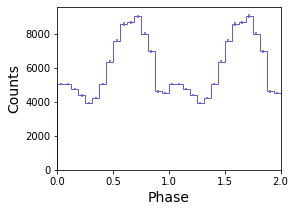

In [128]:
#test nearest peaks using e-fold
testpeaks = p.phasehist(eds,69.53619358876296,bins=32,figsize=(4,3)) 

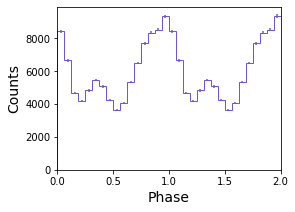

In [129]:
testpeaks = p.phasehist(eds,67.8472080873872,bins=32,figsize=(4,3)) 

> can't figure out what exactly is going on with the mismatch of bin boundaries, but fine for now

In [130]:
#newer model
mo = hendrics.io.load_model('LXP_69_NICER/rxj0529_gti_bary_0.3_10.0_nicer_xti_Z2n_0.01-0.02Hz__mod0__.p') 
print(mo) 
print(mo[0].mean) 
print(mo[0].stddev)

(<Gaussian1D(amplitude=6225.80147551, mean=0.01473913, stddev=0.00000235)>, 'Astropy', None)
Parameter('mean', value=0.014739125491457433)
Parameter('stddev', value=2.3508814965717104e-06, bounds=(1.1754943508222875e-38, None))


In [131]:
1/0.014739125491457433

67.8466304245516

In [132]:
mo

(<Gaussian1D(amplitude=6225.80147551, mean=0.01473913, stddev=0.00000235)>,
 'Astropy',
 None)

# Read in Joint Event File and Look at Pulse Profile

In [162]:
pwd

'/Users/lenatreiber/Desktop/Yale'

In [172]:
com1 = p.readevt(path+'ni3585010107_fil_bar.evt')
com2 = p.readevt(path+'ni3585010106_fil_bar_EN.evt')

In [173]:
#filter energies
com1 = com1[com1['PI']<=800]
com1 = com1[com1['PI']>=30]
com2 = com2[com2['PI']<=800]
com2 = com2[com2['PI']>=30]

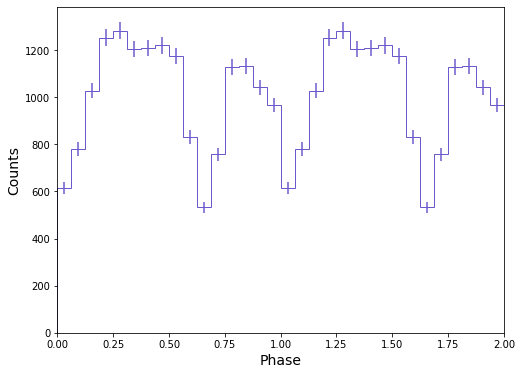

In [174]:
#plot profile with new period
comp1 = p.phasehist(com1,1/0.014580845483718545) #about 68.56

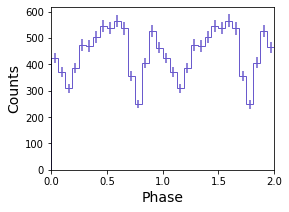

In [177]:
comp2 = p.phasehist(com2,1/0.014580845483718545,figsize=(4,3)) #about 68.56

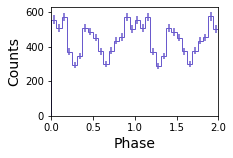

In [180]:
comp2 = p.phasehist(com2,1/0.01440609560258709,figsize=(3,2)) #best for com2: 69.4

In [187]:
from astropy.table import join

In [193]:
com1.remove_columns('EVENT_FLAGS')

In [194]:
com2.remove_columns('EVENT_FLAGS')

In [201]:
com = join(com1,com2,join_type='outer')

In [203]:
len(com) - (len(com1)+len(com2))

0

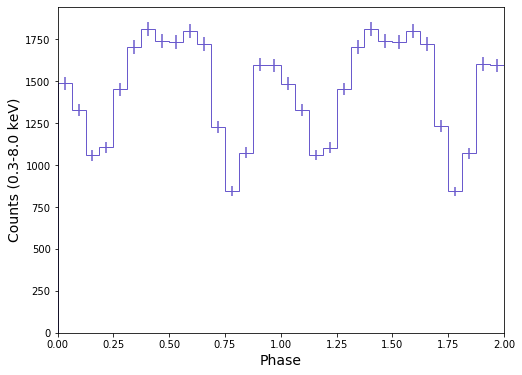

In [206]:
comp = p.phasehist(com,1/0.01458397154022299) #about 68.56
plt.ylabel('Counts (0.3-8.0 keV)',fontsize=14)
sf('newpp')

In [209]:
compd = 1/0.01458397154022299

In [208]:
comsoft = com[com['PI']<=150]
comhard = com[com['PI']>150]

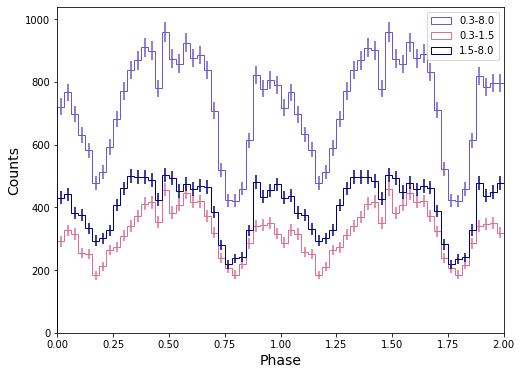

In [248]:
#returns hists and mids
comhd,comhdm = p.phasehist_sh([com,comsoft,comhard],compd,ens=['0.3-8.0','0.3-1.5','1.5-8.0'],bins=64)
sf('comhs')

## find average count rate 
- will add bg later
- first, need exposure time

In [216]:
# find time from each
comtim1 = p.readevt(path+'ni3585010107_fil_bar.evt',ind=2)
comtim2 = p.readevt(path+'ni3585010106_fil_bar_EN.evt',ind=2)
comtim1[:5]

START,STOP
float64,float64
204442167.41851154,204442168.41850874
204442172.41849747,204442173.4184946
204442177.41848305,204442179.41847718
204442187.41845316,204442189.41844702
204442193.41843456,204442200.41841224


In [217]:
comt1 = np.sum(comtim1['STOP']-comtim1['START'])
comt2 = np.sum(comtim2['STOP']-comtim2['START'])

In [220]:
comt = comt1 + comt2
comt #total exposure time; only a problem if there's any overlap

4658.969603538513

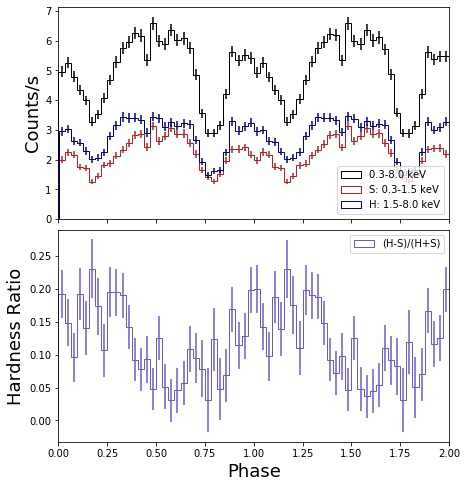

In [255]:
reload(p)
comh = p.phaserate(comhd,comhdm,comt,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','navy'],rate=True,figsize=(7,8))
sf('newhr')

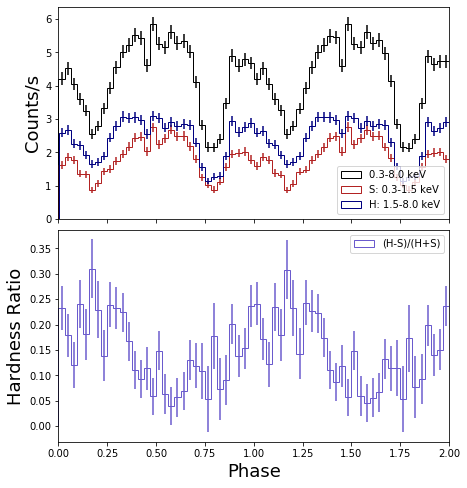

In [256]:
reload(p)
comhbg,comhbgerr = p.phaserate(comhd,comhdm,comt,ens=['0.3-8.0 keV','S: 0.3-1.5 keV','H: 1.5-8.0 keV'],colors=['black','firebrick','navy'],rate=True,figsize=(7,8),
                  bgb=True,bg=bg)
sf('newhrbg')


In [232]:
#find average count rate -- and then check on original avg ct rate
len(com)/comt

4.995310547277241

In [235]:
#old rates
print('avg soft count rate: ',len(soft_evt)/exptime)
print('avg hard count rate: ',len(hard_evt)/exptime) 
print('avg count rate: ',len(ed)/exptime) 
print((len(soft_evt)/exptime)+(len(hard_evt)/exptime))

avg soft count rate:  4.484965190342171
avg hard count rate:  4.432676640497704
avg count rate:  8.917641830839875
8.917641830839875


In [236]:
#new rates
print('avg new soft count rate: ',len(comsoft)/comt)
print('avg new hard count rate: ',len(comhard)/comt) 
print('avg new count rate: ',len(com)/comt) 
print((len(comsoft)/comt)+(len(comhard)/comt))

avg new soft count rate:  2.2067111131593395
avg new hard count rate:  2.7885994341179012
avg new count rate:  4.995310547277241
4.99531054727724


In [251]:
#find estimated bg-subtracted count rate
totrate = comhbg[0][0] #just went up to 32 phase bins (64 total) to match

In [253]:
len(totrate)

64

In [254]:
np.mean(totrate)

4.25514627531753